In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"


fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle, copy
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [4]:
patterns = {}

patterns["VT049W"] = {"name": "Aquarium (self-replicating)", "R": 12, "T": 2,
		"kernels": [
			{"b": [1], "m": 0.272, "s": 0.0595, "h": 0.138, "r": 0.91, "c0": 0, "c1": 0},
			{"b": [1], "m": 0.349, "s": 0.1585, "h": 0.48, "r": 0.62, "c0": 0, "c1": 0},
			{"b": [1, 1/4], "m": 0.2, "s": 0.0332, "h": 0.284, "r": 0.5, "c0": 0, "c1": 0},
			{"b": [0, 1], "m": 0.114, "s": 0.0528, "h": 0.256, "r": 0.97, "c0": 1, "c1": 1},
			{"b": [1], "m": 0.447, "s": 0.0777, "h": 0.5, "r": 0.72, "c0": 1, "c1": 1},
			{"b": [5/6, 1], "m": 0.247, "s": 0.0342, "h": 0.622, "r": 0.8, "c0": 1, "c1": 1},
			{"b": [1], "m": 0.21, "s": 0.0617, "h": 0.35, "r": 0.96, "c0": 2, "c1": 2},
			{"b": [1], "m": 0.462, "s": 0.1192, "h": 0.218, "r": 0.56, "c0": 2, "c1": 2},
			{"b": [1], "m": 0.446, "s": 0.1793, "h": 0.556, "r": 0.78, "c0": 2, "c1": 2},
			{"b": [11/12, 1], "m": 0.327, "s": 0.1408, "h": 0.344, "r": 0.79, "c0": 0, "c1": 1},
			{"b": [3/4, 1], "m": 0.476, "s": 0.0995, "h": 0.456, "r": 0.5, "c0": 0, "c1": 2},
			{"b": [11/12, 1], "m": 0.379, "s": 0.0697, "h": 0.67, "r": 0.72, "c0": 1, "c1": 0},
			{"b": [1], "m": 0.262, "s": 0.0877, "h": 0.42, "r": 0.68, "c0": 1, "c1": 2},
			{"b": [1/6, 1, 0], "m": 0.412, "s": 0.1101, "h": 0.43, "r": 0.82, "c0": 2, "c1": 0},
			{"b": [1], "m": 0.201, "s": 0.0786, "h": 0.278, "r": 0.82, "c0": 2, "c1": 1}],
		"cells": [
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.49, 1.0, 0, 0.03, 0.49, 0.49, 0.28, 0.16, 0.03, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0.47, 0.31, 0.58, 0.51, 0.35, 0.28, 0.22, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.15, 0.32, 0.17, 0.61, 0.97, 0.29, 0.67, 0.59, 0.88, 1.0, 0.92, 0.8, 0.61, 0.42, 0.19, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.25, 0.64, 0.26, 0.92, 0.04, 0.24, 0.97, 1.0, 1.0, 1.0, 1.0, 0.97, 0.71, 0.33, 0.12, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.38, 0.84, 0.99, 0.78, 0.67, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.62, 0.37, 0, 0], [0, 0, 0, 0, 0.04, 0.11, 0, 0.69, 0.75, 0.75, 0.91, 1.0, 1.0, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.81, 0.42, 0.07, 0], [0, 0, 0, 0, 0.44, 0.63, 0.04, 0, 0, 0, 0.11, 0.14, 0, 0.05, 0.64, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92, 0.56, 0.23, 0], [0, 0, 0, 0, 0.11, 0.36, 0.35, 0.2, 0, 0, 0, 0, 0, 0, 0.63, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.49, 0.26, 0], [0, 0, 0, 0, 0, 0.4, 0.37, 0.18, 0, 0, 0, 0, 0, 0.04, 0.41, 0.52, 0.67, 0.82, 1.0, 1.0, 0.91, 0.4, 0.23, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0, 0.05, 0.45, 0.89, 1.0, 0.66, 0.35, 0.09, 0], [0, 0, 0.22, 0, 0, 0, 0.05, 0.36, 0.6, 0.13, 0.02, 0.04, 0.24, 0.34, 0.1, 0, 0.04, 0.62, 1.0, 1.0, 0.44, 0.25, 0, 0], [0, 0, 0, 0.43, 0.53, 0.58, 0.78, 0.9, 0.96, 1.0, 1.0, 1.0, 1.0, 0.71, 0.46, 0.51, 0.81, 1.0, 1.0, 0.93, 0.19, 0.06, 0, 0], [0, 0, 0, 0, 0.23, 0.26, 0.37, 0.51, 0.71, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42, 0.06, 0, 0, 0], [0, 0, 0, 0, 0.03, 0, 0, 0.11, 0.35, 0.62, 0.81, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 0.64, 0.15, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.06, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.05, 0.09, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.28, 0.42, 0.44, 0.34, 0.18, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.34, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91, 0.52, 0.14, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.17, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.35, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.22, 0.92, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.59, 0.09], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.71, 0.16], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.67, 0.83, 0.85, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.68, 0.17], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21, 0.04, 0.12, 0.58, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.57, 0.13], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07, 0, 0, 0, 0.2, 0.64, 0.96, 1.0, 1.0, 1.0, 0.9, 0.24, 0.01], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.29, 0, 0, 0, 0.25, 0.9, 1.0, 1.0, 1.0, 1.0, 0.45, 0.05, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.31, 0.07, 0, 0.46, 0.96, 1.0, 1.0, 1.0, 1.0, 0.51, 0.12, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.26, 0.82, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.05, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.28, 0.74, 1.0, 0.95, 0.87, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.07, 0.69, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.25, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0.72, 0.9, 0.83, 0.7, 0.56, 0.43, 0.14, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.25, 0.37, 0.44, 0.37, 0.24, 0.11, 0.04, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.19, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.4, 0.15, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.14, 0.48, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.62, 0.78, 0.94, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.64, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.02, 0.65, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.78, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.15, 0.48, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.79, 0.05, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.33, 0.56, 0.8, 1.0, 1.0, 1.0, 0.37, 0.6, 0.94, 1.0, 1.0, 1.0, 1.0, 0.68, 0.05, 0, 0, 0], [0, 0, 0, 0, 0.35, 0.51, 0.76, 0.89, 1.0, 1.0, 0.72, 0.15, 0, 0.29, 0.57, 0.69, 0.86, 1.0, 0.92, 0.49, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.38, 0.86, 1.0, 1.0, 0.96, 0.31, 0, 0, 0, 0, 0.02, 0.2, 0.52, 0.37, 0.11, 0, 0, 0, 0], [0, 0, 0.01, 0, 0, 0.07, 0.75, 1.0, 1.0, 1.0, 0.48, 0.03, 0, 0, 0, 0, 0, 0.18, 0.07, 0, 0, 0, 0, 0], [0, 0.11, 0.09, 0.22, 0.15, 0.32, 0.71, 0.94, 1.0, 1.0, 0.97, 0.54, 0.12, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.06, 0.33, 0.47, 0.51, 0.58, 0.77, 0.95, 1.0, 1.0, 1.0, 1.0, 0.62, 0.12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.04, 0.4, 0.69, 0.88, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.68, 0.22, 0.02, 0, 0, 0.01, 0, 0, 0, 0, 0, 0, 0], [0, 0.39, 0.69, 0.91, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85, 0.52, 0.35, 0.24, 0.17, 0.07, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.29, 0.82, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.67, 0.29, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.2, 0.51, 0.77, 0.96, 0.93, 0.71, 0.4, 0.16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.08, 0.07, 0.03, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
			]
}

patterns["5N7KKM"] = {"name": "Aquarium (swarm)", "R": 12, "T": 2,
		"kernels": [
			{"b": [1], "m": 0.22, "s": 0.0628, "h": 0.174, "r": 0.87, "c0": 0, "c1": 0},
			{"b": [1], "m": 0.351, "s": 0.1539, "h": 0.46, "r": 0.52, "c0": 0, "c1": 0},
			{"b": [1, 1/4], "m": 0.177, "s": 0.0333, "h": 0.31, "r": 0.58, "c0": 0, "c1": 0},
			{"b": [0, 1], "m": 0.126, "s": 0.0525, "h": 0.242, "r": 0.89, "c0": 1, "c1": 1},
			{"b": [1], "m": 0.437, "s": 0.0797, "h": 0.508, "r": 0.78, "c0": 1, "c1": 1},
			{"b": [3/4, 1], "m": 0.234, "s": 0.0369, "h": 0.566, "r": 0.79, "c0": 1, "c1": 1},
			{"b": [1], "m": 0.179, "s": 0.0653, "h": 0.406, "r": 1.0, "c0": 2, "c1": 2},
			{"b": [1], "m": 0.489, "s": 0.1213, "h": 0.27, "r": 0.64, "c0": 2, "c1": 2},
			{"b": [1], "m": 0.419, "s": 0.1775, "h": 0.588, "r": 0.96, "c0": 2, "c1": 2},
			{"b": [11/12, 1], "m": 0.341, "s": 0.1388, "h": 0.294, "r": 0.66, "c0": 0, "c1": 1},
			{"b": [3/4, 1], "m": 0.469, "s": 0.1054, "h": 0.388, "r": 0.69, "c0": 0, "c1": 2},
			{"b": [1, 11/12], "m": 0.369, "s": 0.0721, "h": 0.62, "r": 0.61, "c0": 1, "c1": 0},
			{"b": [1], "m": 0.219, "s": 0.0898, "h": 0.348, "r": 0.81, "c0": 1, "c1": 2},
			{"b": [1/6, 1], "m": 0.385, "s": 0.1102, "h": 0.436, "r": 0.81, "c0": 2, "c1": 0},
			{"b": [1], "m": 0.208, "s": 0.0749, "h": 0.39, "r": 0.71, "c0": 2, "c1": 1}],
		"cells": [
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.12, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.49, 0, 0, 0, 0, 0, 0, 0.23, 0.47, 0.31, 0.93, 0.75, 0, 0, 0, 0], [0, 0, 0, 0.23, 0, 0, 0.65, 0.68, 0.12, 0, 0, 0, 0.02, 0.40, 0.82, 0.86, 0, 0.19, 0, 0], [0, 0, 0.01, 0.01, 0.77, 1.00, 0.98, 1.00, 0.97, 0.85, 0.70, 0.55, 0.12, 0.15, 0.01, 0, 0, 0.95, 0, 0], [0, 0, 0, 0.66, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.74, 0.76, 0.27, 0, 0, 0.18, 0.59, 0.31, 0], [0, 0.04, 0.08, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88, 0.68, 0.07, 0, 0, 0, 0, 0, 0], [0, 0, 0.29, 1.00, 1.00, 1.00, 1.00, 0.90, 1.00, 0.92, 0.58, 0.84, 0.89, 0.39, 0, 0, 0.04, 1.00, 0, 0], [0, 0.06, 0.27, 1.00, 1.00, 1.00, 0.82, 0.39, 0, 0, 0, 0.12, 0.87, 0.70, 0.58, 0.04, 0.40, 1.00, 0.35, 0], [0, 0.21, 0.38, 1.00, 1.00, 0.66, 0, 0, 0, 0, 0, 0, 1.00, 0.79, 0.74, 0.16, 0.31, 0.42, 0, 0], [0, 0.26, 0.50, 1.00, 1.00, 0.46, 0, 0, 0, 0, 0, 0.40, 1.00, 1.00, 0.71, 0.16, 0, 0.22, 0, 0], [0, 0.14, 0.48, 1.00, 1.00, 0.77, 0, 0, 0, 0, 0, 1.00, 1.00, 1.00, 0.79, 0, 0, 0, 0, 0], [0, 0, 0.16, 1.00, 1.00, 1.00, 0.19, 0, 0, 0.09, 0.20, 0.57, 1.00, 1.00, 0.74, 0, 0, 0, 0, 0], [0, 0, 0, 0.59, 1.00, 1.00, 0.85, 0.75, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.47, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.95, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.96, 0.44, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.25, 0.79, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.96, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.04, 0.06, 0.26, 0.61, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0, 0.32, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.15, 0, 0.02, 0.23, 0.24, 0.05, 0, 0, 0.25, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.04, 0, 0, 0.08, 0, 0, 0, 0, 0, 0, 0]],
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.03, 0.43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.14, 0.47, 0, 0, 0.27, 0.92, 0.87, 0.70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.86, 1.00, 0.66, 1.00, 1.00, 1.00, 1.00, 0.33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 0.13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0.22, 0.30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.76, 1.00, 1.00, 1.00, 1.00, 1.00, 0.83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.71, 1.00, 1.00, 1.00, 1.00, 0.77, 0.81, 0.75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.69, 1.00, 1.00, 1.00, 0.88, 0.24, 0.35, 0.62, 0.35, 0.09, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.29, 1.00, 1.00, 1.00, 0.98, 0.38, 0.13, 0.65, 0.88, 0.32, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.09, 1.00, 1.00, 1.00, 0.93, 0.77, 0.88, 0.24, 0.03, 0.69, 1.00, 0.78, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.44, 1.00, 1.00, 1.00, 1.00, 1.00, 0.76, 0.83, 1.00, 0.92, 0.17, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.36, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.12, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.06, 0.39, 0.79, 1.00, 1.00, 1.00, 0.48, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.16, 0.59, 1.00, 1.00, 1.00, 0.13, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.16, 0.02, 0, 0, 0, 0, 0, 0, 0, 0]],
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.51, 0.46, 0.26, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.38, 1.00, 1.00, 0.96, 0.85, 0.57, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.06, 0.63, 1.00, 1.00, 1.00, 1.00, 0.96, 0.70, 0.08, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.01, 0.36, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.82, 0.49, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.05, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.99, 0.65, 0.04, 0, 0, 0, 0], [0, 0, 0.01, 0, 0.08, 0.52, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.93, 0, 0, 0, 0, 0], [0, 0, 0.03, 0, 0.09, 0.49, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.58, 0.04, 0, 0, 0, 0, 0], [0, 0, 0.02, 0, 0.08, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 0.81, 0, 0, 0, 0, 0.08, 0.01, 0, 0], [0, 0, 0, 0, 0.04, 0.47, 1.00, 1.00, 1.00, 1.00, 0.40, 0, 0, 0, 0, 0.77, 0.85, 0.35, 0, 0], [0, 0, 0, 0, 0.03, 0.41, 1.00, 1.00, 1.00, 1.00, 0.20, 0, 0, 0.01, 1.00, 1.00, 1.00, 0.55, 0, 0], [0, 0, 0, 0, 0, 0.30, 0.98, 1.00, 1.00, 1.00, 0.68, 0.09, 0.26, 1.00, 1.00, 1.00, 1.00, 0.70, 0.19, 0], [0, 0, 0, 0, 0, 0.13, 0.55, 0.95, 1.00, 1.00, 1.00, 0.89, 1.00, 1.00, 1.00, 1.00, 1.00, 0.85, 0.67, 0.24], [0, 0, 0, 0, 0, 0.02, 0.31, 0.63, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88, 0.45], [0, 0, 0, 0, 0, 0, 0.12, 0.44, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.91, 0.36], [0, 0, 0, 0, 0, 0, 0, 0.16, 0.48, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.86, 0.06], [0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.32, 0.70, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.28, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06, 0.18, 0.32, 0.57, 0.90, 1.00, 1.00, 1.00, 0.08, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.12, 0.25, 0.39, 0.31, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
			]
}

patterns["5N7KKM_2"] = {"name": "Aquarium (swarm, twin)", "R": 12, "T": 2,
		"cells": [
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.15, 0.17, 0.02, 0, 0, 0.06, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.19, 0.46, 0.39, 0.49, 1.00, 1.00, 1.00, 0.61, 0.28, 0.21, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.30, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.59, 0.11, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.79, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.78, 0.88, 1.00, 1.00, 1.00, 0.56, 0.07, 0.03, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.18, 0.88, 0.97, 0.99, 1.00, 1.00, 1.00, 0.23, 0, 0, 0.13, 0.91, 1.00, 1.00, 1.00, 0.46, 0.10, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.75, 0.48, 0.42, 0.58, 1.00, 1.00, 1.00, 0, 0, 0, 0, 0.10, 0.95, 1.00, 1.00, 1.00, 0.84, 0.21, 0.07, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0.01, 0, 0, 0, 0.70, 1.00, 0, 0, 0, 0, 0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.32, 0.13, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.16, 0.46, 0.12, 0.11, 0.22, 0.07, 0, 0, 0.72, 0.95, 1.00, 1.00, 1.00, 1.00, 1.00, 0.29, 0.14, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.17, 1.00, 0.90, 0.41, 0.09, 0, 0, 0, 0.41, 1.00, 1.00, 1.00, 1.00, 0.06, 0.15, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.02, 0, 0.33, 0.70, 1.00, 1.00, 0.74, 0.33, 0.03, 0, 0, 0.58, 1.00, 1.00, 1.00, 0.27, 0, 0.12, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.71, 1.00, 0.95, 0.68, 0.61, 0.44, 0.19, 0.14, 0.92, 1.00, 1.00, 1.00, 0.05, 0, 0, 0.01, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.38, 0.94, 0.87, 0.04, 0.06, 0.49, 0.47, 0.71, 1.00, 1.00, 1.00, 1.00, 0, 0, 0.04, 0.17, 0.03, 0.02, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.28, 0.71, 0, 0, 0, 0.09, 0.31, 0.35, 0.18, 0.20, 0.58, 0.84, 0, 0, 0.34, 1.00, 0.68, 0.08, 0.07, 0.16, 0.09, 0.04, 0, 0, 0, 0], [0, 0, 0, 0, 0.03, 0.01, 0.34, 0.03, 0.16, 0, 0, 0, 0, 0, 0, 0, 0.51, 1.00, 1.00, 0.30, 0, 0, 0, 0.10, 0.17, 0.14, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.49, 0.94, 0.99, 0.21, 0, 0, 0.19, 0.80, 0.91, 0.73, 0.27, 0.10, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.38, 0.64, 0, 0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 0.94, 0.30, 0.05, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.42, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88, 0.22, 0.04], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.62, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.47, 0.01], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.68, 1.00, 1.00, 0.50, 0.58, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88, 0.09], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.66, 1.00, 0.03, 0, 0.05, 0.94, 1.00, 0.81, 0.99, 1.00, 1.00, 0.21], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.52, 0.54, 0.07, 0, 0.22, 0.73, 0, 0, 0.55, 1.00, 1.00, 0.30], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.51, 0.69, 0.29, 0, 0, 0, 0, 0, 0.39, 1.00, 1.00, 0.19], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14, 0.88, 0.44, 0, 0, 0, 0, 0, 0.61, 1.00, 1.00, 0.06], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.29, 1.00, 0.62, 0.02, 0, 0, 0, 0.34, 1.00, 1.00, 0.97, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05, 0, 0.35, 0.91, 1.00, 1.00, 0.29, 0.09, 0.08, 1.00, 1.00, 1.00, 1.00, 0.66, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.53, 0.87, 0.82, 1.00, 0.59, 0.16, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.06, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.61, 0.63, 0.20, 0.18, 0, 0.22, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.65, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.55, 0.96, 0.97, 1.00, 1.00, 1.00, 1.00, 0.15, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.80, 1.00, 1.00, 1.00, 0.13, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.26, 0.85, 1.00, 1.00, 0, 0, 0.05, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.53, 0.61, 0, 0, 0, 0.05, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.28, 0, 0, 0, 0, 0]],
			[[0, 0, 0, 0, 0, 0, 0.37, 0.46, 0.45, 0.37, 0.34, 0.13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.11, 0.83, 0.83, 0.97, 1.00, 1.00, 1.00, 0.39, 0.02, 0, 0, 0.10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.13, 0.86, 0.64, 0.14, 0.54, 0.48, 0.45, 0.37, 0.27, 0.79, 0.46, 0.12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.30, 0.69, 0, 0, 0.07, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.78, 0.21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.27, 0.51, 0, 0, 0.01, 0.90, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.84, 0.19, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.05, 1.00, 1.00, 0.68, 0.68, 1.00, 1.00, 1.00, 0.99, 1.00, 1.00, 1.00, 0.53, 0.01, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.18, 1.00, 1.00, 1.00, 0.60, 0.15, 0.98, 1.00, 1.00, 0.90, 1.00, 1.00, 1.00, 0.43, 0.04, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.83, 0.88, 0.96, 1.00, 1.00, 0.16, 0, 0.94, 1.00, 1.00, 1.00, 1.00, 1.00, 0.57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.60, 0, 0, 0, 0, 0.11, 0.52, 1.00, 1.00, 1.00, 1.00, 1.00, 0.89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21, 0.84, 1.00, 1.00, 1.00, 1.00, 0.89, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15, 0.61, 0.61, 0.69, 0.82, 0.87, 0.22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.07, 0.68, 0.20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.12, 0.57, 0.68, 0.26, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.30, 0.91, 1.00, 1.00, 1.00, 0.82, 0.11, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.84, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.33, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.58, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.53, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.71, 1.00, 1.00, 1.00, 0.94, 1.00, 1.00, 1.00, 0.68, 0.03], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.79, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.51, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08, 0.63, 0.98, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.12, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.26, 0.70, 0.74, 0.78, 0.93, 1.00, 1.00, 0.78, 0.11, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.30, 0.23, 0.34, 0.61, 0.84, 1.00, 0.60, 0.09, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.53, 0.58, 0.30, 0.78, 1.00, 0.74, 0.33, 0.05, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07, 1.00, 1.00, 1.00, 0.57, 0.62, 0.83, 0.43, 0.07, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.61, 1.00, 1.00, 0, 0, 0.62, 1.00, 0.98, 0.24, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.78, 0.81, 0.23, 0, 0.32, 1.00, 1.00, 1.00, 0.28, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.40, 0.09, 0.10, 0.20, 1.00, 1.00, 0.95, 1.00, 0.99, 0.09, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.47, 0, 0, 0.59, 1.00, 0.50, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.58, 0.50, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.01, 0.09, 0.17, 0.07, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.18, 0.40, 0.70, 1.00, 0.86, 0.39, 0.14, 0.07, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.08, 0.62, 1.00, 1.00, 1.00, 1.00, 1.00, 0.86, 0.77, 0.63, 0.40, 0.13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.93, 0.59, 0.34, 0.25, 0.07, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0.87, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.98, 0.89, 0.52, 0.17, 0.03, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.27, 0.87, 1.00, 1.00, 1.00, 0.90, 0.95, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.56, 0.30, 0.14, 0.01, 0, 0, 0, 0, 0, 0, 0, 0], [0.29, 0.85, 1.00, 1.00, 0.95, 0.89, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.87, 0.72, 0.50, 0.19, 0, 0, 0, 0, 0, 0, 0, 0], [0.31, 0.81, 0.99, 1.00, 0.92, 0.96, 1.00, 1.00, 1.00, 1.00, 0.84, 0.75, 0.87, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.65, 0.19, 0, 0, 0, 0, 0, 0, 0], [0.19, 0.49, 0.79, 0.99, 1.00, 1.00, 1.00, 1.00, 1.00, 0.55, 0.15, 0.21, 0.65, 0.75, 0.62, 0.78, 1.00, 1.00, 1.00, 1.00, 1.00, 0.65, 0.11, 0, 0, 0, 0, 0, 0], [0, 0.17, 0.69, 0.88, 0.96, 1.00, 1.00, 1.00, 0.27, 0, 0, 0, 0, 0, 0, 0.87, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.40, 0.01, 0, 0, 0, 0, 0], [0, 0, 0.32, 0.53, 0.75, 0.95, 1.00, 0.23, 0, 0, 0, 0, 0, 0, 0.80, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.76, 0.16, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.28, 0.46, 0.27, 0.15, 0, 0, 0, 0, 0, 0.95, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.98, 0.35, 0.04, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.10, 0.79, 1.00, 1.00, 1.00, 1.00, 0.96, 1.00, 1.00, 1.00, 1.00, 1.00, 0.94, 0.45, 0.07, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.72, 0.86, 0.98, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.90, 0.51, 0.09, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11, 0.44, 0.73, 0.95, 1.00, 1.00, 1.00, 1.00, 1.00, 0.84, 0.93, 1.00, 1.00, 0.75, 0.15, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.40, 0.82, 1.00, 1.00, 1.00, 0.75, 0.25, 0.51, 0.98, 1.00, 1.00, 1.00, 0.25, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08, 0.68, 0.97, 1.00, 0, 0, 0, 0.84, 1.00, 1.00, 1.00, 1.00, 0.29, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.57, 0.31, 0, 0, 0, 0.50, 0.91, 1.00, 1.00, 1.00, 0.97, 0.34, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.41, 0.67, 0.99, 1.00, 1.00, 0.98, 0.43, 0.02, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.32, 0.84, 1.00, 1.00, 1.00, 0.97, 0.47, 0.04, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.24, 0.72, 0.98, 1.00, 1.00, 1.00, 1.00, 0.50, 0.03, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14, 0.69, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.43, 0.01, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.17, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.38, 0.02, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.78, 1.00, 1.00, 1.00, 1.00, 1.00, 0.97, 1.00, 1.00, 1.00, 0.51, 0.05, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.62, 0.95, 1.00, 0.98, 0.95, 0.83, 0.89, 1.00, 1.00, 1.00, 0.36, 0, 0, 0.01, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.50, 0.88, 0.95, 0.87, 0.86, 0.90, 1.00, 1.00, 1.00, 0.85, 0.08, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.49, 0.87, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.28, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.31, 0.73, 0.99, 1.00, 1.00, 1.00, 1.00, 1.00, 0.51, 0.03, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.03, 0.52, 0.84, 0.97, 1.00, 1.00, 1.00, 0.56, 0.07, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.40, 0.66, 0.86, 0.95, 0.26, 0, 0, 0, 0, 0, 0, 0, 0]],
			]
}

patterns["5N7KKM_g"] = {"name": "Aquarium (swarm, gyrating)", "R": 12, "T": 2,
		"cells": [
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.01, 0, 0.06, 0.13, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.02, 0.19, 0.43, 0.53, 0.69, 0.80, 0.51, 0, 0, 0, 0.16, 0.11, 0, 0, 0, 0, 0], [0, 0, 0, 0.11, 0.47, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0, 0, 0.07, 0, 0, 0], [0, 0, 0, 0.57, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.97, 0.93, 0, 0, 0, 0, 0], [0, 0.13, 0.49, 1.00, 1.00, 0.90, 0.59, 0, 0, 0, 0, 0.12, 1.00, 1.00, 1.00, 1.00, 0.94, 0.69, 0, 0.54, 0, 0], [0.06, 0.21, 0.65, 1.00, 1.00, 1.00, 0.76, 0, 0, 0, 0, 0, 0.67, 1.00, 1.00, 1.00, 0.91, 0.38, 0, 0.04, 0.27, 0], [0.06, 0.24, 0.75, 1.00, 1.00, 1.00, 0.98, 0.05, 0, 0, 0, 0, 0.40, 0.74, 1.00, 1.00, 0.89, 0.27, 0, 0, 0, 0], [0.08, 0.27, 0.78, 1.00, 1.00, 1.00, 1.00, 0.05, 0, 0, 0, 0, 0.34, 0.51, 0.72, 0.93, 0.81, 0.35, 0, 0, 0, 0], [0.11, 0.24, 0.71, 1.00, 1.00, 1.00, 0.98, 0, 0, 0, 0, 0.14, 0.53, 0.57, 0.52, 0.37, 0.68, 0.48, 0.07, 0, 0, 0], [0, 0.12, 0.26, 0.98, 1.00, 1.00, 1.00, 1.00, 1.00, 0.78, 0.75, 1.00, 1.00, 1.00, 0.84, 0.18, 0.33, 0.45, 0.15, 0, 0, 0], [0, 0.02, 0.11, 0.50, 0.86, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.96, 0.79, 0.20, 0.16, 0.33, 0.17, 0, 0, 0], [0, 0, 0.04, 0.14, 0.28, 0.46, 0.43, 0.88, 1.00, 1.00, 1.00, 1.00, 0.78, 0.71, 0.63, 0.05, 0, 0.23, 0.32, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.34, 0.86, 0.32, 0.02, 0.02, 0.03, 0.02, 0.05, 0.07, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09, 0.70, 0.27, 0, 0, 0.25, 0.20, 0.10, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.37, 1.00, 0.35, 0.22, 0.49, 0, 0, 0.79, 0.67, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.00, 0.14, 0.12, 0.61, 0, 0, 0.83, 0.34, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.55, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.23, 0.32, 0.09, 0.03, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.51, 0.97, 1.00, 0.91, 0.58, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.44, 0.88, 1.00, 0.72, 0.38, 0.48, 0.64, 0.59, 0.62, 0.99, 0.77, 0.50, 0, 0, 0, 0, 0], [0, 0, 0, 0.47, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.46, 0.37, 0.71, 0.68, 0.21, 0, 0, 0, 0, 0], [0, 0.15, 0.61, 1.00, 1.00, 1.00, 1.00, 0.97, 0.85, 0.67, 0.39, 0.57, 0.99, 0.91, 0.99, 0.85, 0.17, 0, 0, 0, 0, 0], [0.03, 0.35, 0.93, 1.00, 1.00, 1.00, 1.00, 0.97, 0.84, 0.62, 0.13, 0.24, 0.99, 1.00, 0.94, 0.95, 0.52, 0, 0, 0, 0, 0], [0.11, 0.56, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.90, 0.66, 0.05, 0.04, 0.73, 0.71, 0.55, 0.88, 0.70, 0, 0, 0, 0, 0], [0.19, 0.83, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.83, 0.43, 0, 0, 0.40, 0.71, 0.60, 0.52, 0.28, 0, 0, 0, 0, 0], [0.18, 0.81, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.80, 0.30, 0, 0, 0, 0.30, 0.69, 0.86, 0.39, 0, 0, 0, 0, 0], [0.08, 0.47, 0.99, 1.00, 1.00, 1.00, 1.00, 0.55, 0.13, 0, 0, 0, 0, 0, 0, 0.40, 0, 0, 0, 0, 0, 0], [0, 0.26, 0.63, 1.00, 1.00, 1.00, 1.00, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0.06, 0.28, 0.60, 0.65, 0.80, 0.79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
			[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.01, 0.01, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.02, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07, 0.10, 0.11, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09, 0.17, 0.34, 0.43, 0.48, 0.22, 0.06, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.11, 0.25, 0.38, 0.56, 0.68, 1.00, 1.00, 1.00, 1.00, 0.95, 0.33, 0.18, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.19, 0.42, 0.69, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.74, 0.49, 0.02, 0, 0], [0, 0, 0, 0, 0, 0.01, 0.11, 0.45, 0.64, 0.88, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.89, 0.26, 0, 0], [0, 0, 0, 0, 0.08, 0.73, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.91, 0.36, 0], [0, 0, 0, 0.06, 0.29, 1.00, 1.00, 1.00, 1.00, 0.94, 0.63, 0.61, 0.91, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.64, 0], [0, 0.01, 0.07, 0.40, 0.73, 1.00, 1.00, 1.00, 1.00, 1.00, 0.23, 0, 0.05, 0.71, 1.00, 1.00, 1.00, 1.00, 1.00, 0.99, 0.90, 0.39], [0, 0.03, 0.12, 0.51, 0.90, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.51, 0.16, 0.28, 1.00, 0.96, 0.99, 1.00, 1.00, 0.94, 0.83, 0.59], [0, 0.03, 0.13, 0.56, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.30, 0.28, 0.40, 0.80, 0.88, 0.98, 0.95, 0.83, 0.71, 0.52], [0, 0, 0.05, 0.42, 0.83, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.24, 0, 0.55, 0.64, 0.71, 0.62, 0.48, 0.38, 0.19], [0, 0, 0, 0.23, 0.54, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.98, 0.68, 0, 0.43, 0.58, 0.55, 0.38, 0.25, 0.16, 0], [0, 0, 0, 0, 0, 0.19, 0.52, 1.00, 0.99, 0.86, 0.66, 0.60, 0.55, 0.51, 0, 0, 0.05, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.35, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
			]
}

patterns["5N7KKM_2"]["kernels"] = patterns["5N7KKM"]["kernels"]
patterns["5N7KKM_g"]["kernels"] = patterns["5N7KKM"]["kernels"]

In [5]:
from typing import Any
from functools import partial
from dataclasses import dataclass
from collections import namedtuple

import jax
import jax.numpy as jnp

# from lenia.patterns import patterns


Carry = namedtuple('Carry', [ 'world', 'param', 'asset', 'temp' ])
Accum = namedtuple('Accum', [ 'phenotype', 'stats' ])
Param = namedtuple('Params', [ 'm', 's', 'h' ])
Asset = namedtuple('Asset', [ 'fK', 'X', 'reshape_c_k', 'reshape_k_c', 'R', 'T' ])
Temp = namedtuple('Temp', [ 'last_center', 'last_shift', 'total_shift', 'last_angle' ])
Stats = namedtuple('Stats', [ 'mass', 'center_x', 'center_y', 'linear_velocity', 'angle', 'angular_velocity', 'is_empty', 'is_full', 'is_spread' ])
Others = namedtuple('Others', [ 'D', 'K', 'cells', 'init_cells' ])


bell = lambda x, mean, stdev: jnp.exp(-((x-mean)/stdev)**2 / 2)
growth = lambda x, mean, stdev: 2 * bell(x, mean, stdev) - 1


@dataclass
class ConfigLenia:
	# Init pattern
	pattern_id: str = "VT049W"

	# World
	world_size: int = 128
	world_scale: int = 1

	# Simulation
	n_step: int = 200

	# Genotype
	n_params_size: int = 3
	n_cells_size: int = 32


class Lenia:

	def __init__(self, config: ConfigLenia):
		self._config = config
		self.pattern = patterns[self._config.pattern_id]

		# Genotype
		self.n_kernel = len(self.pattern["kernels"])  # k, number of kernels
		self.n_channel = len(self.pattern["cells"])  # c, number of channels
		self.n_params = self._config.n_params_size * self.n_kernel  # p*k, number of parameters inside genotype
		self.n_cells = self._config.n_cells_size * self._config.n_cells_size * self.n_channel  # e*e*c, number of embryo cells inside genotype
		self.n_gene = self.n_params + self.n_cells  # size of genotype

	def create_world_from_cells(self, cells):
		mid = self._config.world_size // 2

		# scale cells
		scaled_cells = cells.repeat(self._config.world_scale, axis=-3).repeat(self._config.world_scale, axis=-2)
		cy, cx = scaled_cells.shape[0], scaled_cells.shape[1]

		# create empty world and place cells
		A = jnp.zeros((self._config.world_size, self._config.world_size, self.n_channel))  # (y, x, c,)
		A = A.at[mid-cx//2:mid+cx-cx//2, mid-cy//2:mid+cy-cy//2, :].set(scaled_cells)
		return A

	def load_pattern(self, pattern):
		# unpack pattern data
		cells = jnp.transpose(jnp.asarray(pattern['cells']), axes=[1, 2, 0])  # (y, x, c,)
		kernels = pattern['kernels']
		R = pattern['R'] * self._config.world_scale
		T = pattern['T']

		# get params from pattern (to be put in genotype)
		m = jnp.array([k['m'] for k in kernels])  # (k,)
		s = jnp.array([k['s'] for k in kernels])  # (k,)
		h = jnp.array([k['h'] for k in kernels])  # (k,)
		init_params = jnp.vstack([m, s, h])  # (p, k,)

		# get reshaping arrays (unfold and fold)
		reshape_c_k = jnp.zeros(shape=(self.n_channel, self.n_kernel))  # (c, k,)
		reshape_k_c = jnp.zeros(shape=(self.n_kernel, self.n_channel))  # (k, c,)
		for i, k in enumerate(kernels):
			reshape_c_k = reshape_c_k.at[k['c0'], i].set(1.0)
			reshape_k_c = reshape_k_c.at[i, k['c1']].set(1.0)

		# calculate kernels and related stuff
		mid = self._config.world_size // 2
		X = jnp.mgrid[-mid:mid, -mid:mid] / R  # (d, y, x,), coordinates
		D = jnp.linalg.norm(X, axis=0)  # (y, x,), distance from origin
		Ds = [D * len(k['b']) / k['r'] for k in kernels]  # (y, x,)*k
		Ks = [(D<len(k['b'])) * jnp.asarray(k['b'])[jnp.minimum(D.astype(int),len(k['b'])-1)] * bell(D%1, 0.5, 0.15) for D,k in zip(Ds, kernels)]  # (x, y,)*k
		K = jnp.dstack(Ks)  # (y, x, k,), kernels
		nK = K / jnp.sum(K, axis=(0, 1), keepdims=True)  # (y, x, k,), normalized kernels
		fK = jnp.fft.fft2(jnp.fft.fftshift(nK, axes=(0, 1)), axes=(0, 1))  # (y, x, k,), FFT of kernels

		# pad pattern cells into initial cells (to be put in genotype)
		cy, cx = cells.shape[0], cells.shape[1]
		py, px = self._config.n_cells_size - cy, self._config.n_cells_size - cx
		init_cells = jnp.pad(cells, pad_width=((py//2, py-py//2), (px//2, px-px//2), (0,0)), mode='constant')  # (e, e, c,)

		# create world from initial cells
		A = self.create_world_from_cells(init_cells)

		# pack initial data
		init_carry = Carry(
			world = A,
			param = Param(m, s, h),
			asset = Asset(fK, X, reshape_c_k, reshape_k_c, R, T),
			temp  = Temp(jnp.zeros(2), jnp.zeros(2, dtype=int), jnp.zeros(2, dtype=int), 0.0),
		)
		init_genotype = jnp.concatenate([init_params.flatten(), init_cells.flatten()])
		other_asset = Others(D, K, cells, init_cells)
		return init_carry, init_genotype, other_asset

	def express_genotype(self, carry, genotype):
		params = genotype[:self.n_params].reshape((self._config.n_params_size, self.n_kernel))
		cells = genotype[self.n_params:].reshape((self._config.n_cells_size, self._config.n_cells_size, self.n_channel))

		m, s, h = params
		A = self.create_world_from_cells(cells)

		carry = carry._replace(world=A)
		carry = carry._replace(param=Param(m, s, h))
		return carry

	@partial(jax.jit, static_argnames=("self", "phenotype_size", "center_phenotype", "record_phenotype",))
	def step(self, carry: Carry, unused: Any, phenotype_size, center_phenotype, record_phenotype):
		# unpack data from last step
		A = carry.world
		m, s, h = carry.param
		fK, X, reshape_c_k, reshape_k_c, R, T = carry.asset
		last_center, last_shift, total_shift, last_angle = carry.temp
		m = m[None, None, ...]  # (1, 1, k,)
		s = s[None, None, ...]  # (1, 1, k,)
		h = h[None, None, ...]  # (1, 1, k,)

		# center world for accurate calculation of center and velocity
		A = jnp.roll(A, -last_shift, axis=(-3, -2))  # (y, x, c,)

		# Lenia step
		fA = jnp.fft.fft2(A, axes=(-3, -2))  # (y, x, c,)
		fA_k = jnp.dot(fA, reshape_c_k)  # (y, x, k,)
		U_k = jnp.real(jnp.fft.ifft2(fK * fA_k, axes=(-3, -2)))  # (y, x, k,)
		G_k = growth(U_k, m, s) * h  # (y, x, k,)
		G = jnp.dot(G_k, reshape_k_c)  # (y, x, c,)
		next_A = jnp.clip(A + 1/T * G, 0, 1)  # (y, x, c,)

		# calculate center
		m00 = A.sum()
		AX = next_A.sum(axis=-1)[None, ...] * X  # (d, y, x,)
		center = AX.sum(axis=(-2, -1)) / m00  # (d,)
		shift = (center * R).astype(int)
		total_shift += shift

		# get phenotype
		if record_phenotype:
			if center_phenotype:
				phenotype = next_A
			else:
				phenotype = jnp.roll(next_A, total_shift - shift, axis=(0, 1))
			mid = self._config.world_size // 2
			half_size = phenotype_size // 2
			phenotype = phenotype[mid-half_size:mid+half_size, mid-half_size:mid+half_size]
		else:
			phenotype = None

		# calculate mass and velocity
		mass = m00 / R / R
		actual_center = center + total_shift / R
		center_diff = center - last_center + last_shift / R
		linear_velocity = jnp.linalg.norm(center_diff) * T

		# calculate angular velocity
		angle = jnp.arctan2(center_diff[1], center_diff[0]) / jnp.pi  # angle = [-1.0, 1.0]
		angle_diff = (angle - last_angle + 3) % 2 - 1
		angle_diff = jax.lax.cond(linear_velocity > 0.01, lambda: angle_diff, lambda: 0.0)
		angular_velocity = angle_diff * T

		# check if world is empty or full
		is_empty = (next_A < 0.1).all(axis=(-3, -2)).any()
		borders = next_A[..., 0, :, :].sum() + next_A[..., -1, :, :].sum() + next_A[..., :, 0, :].sum() + next_A[..., :, -1, :].sum()
		is_full = borders > 0.1
		is_spread = A[mid-half_size:mid+half_size, mid-half_size:mid+half_size].sum()/m00 < 0.9

		# pack data for next step
		carry = carry._replace(world=next_A)
		carry = carry._replace(temp=Temp(center, shift, total_shift, angle))
		stats = Stats(mass, actual_center[1], -actual_center[0], linear_velocity, angle, angular_velocity, is_empty, is_full, is_spread)
		accum = Accum(phenotype, stats)
		return carry, accum

In [78]:
config_lenia = ConfigLenia()

In [79]:
lenia = Lenia(config_lenia)

In [85]:
lenia_step = partial(lenia.step, phenotype_size=config_lenia.world_size, center_phenotype=False, record_phenotype=True)

In [90]:
init_carry, init_genotype, other_asset = lenia.load_pattern(lenia.pattern)

In [91]:
carry = lenia.express_genotype(init_carry, init_genotype)

In [92]:
carry, accum = jax.lax.scan(lenia_step, init=carry, xs=jnp.arange(lenia._config.n_step))

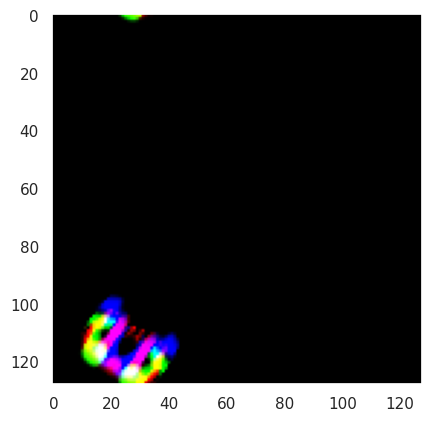

In [89]:
plt.imshow(accum.phenotype[172])
plt.grid(False)

In [93]:
jax.tree.map(lambda x, y: (x-y).sum() if isinstance(x, jnp.ndarray) else x-y, init_carry, carry)

Carry(world=Array(-457.37903, dtype=float32), param=Params(m=Array(0., dtype=float32), s=Array(0., dtype=float32), h=Array(0., dtype=float32)), asset=Asset(fK=Array(0.+0.j, dtype=complex64), X=Array(0., dtype=float32), reshape_c_k=Array(0., dtype=float32), reshape_k_c=Array(0., dtype=float32), R=Array(0, dtype=int32, weak_type=True), T=Array(0, dtype=int32, weak_type=True)), temp=Temp(last_center=Array(-0.02654741, dtype=float32), last_shift=Array(-1, dtype=int32), total_shift=Array(-17, dtype=int32), last_angle=Array(0.19155169, dtype=float32)))

In [101]:
2*(9)

18

In [102]:
2**18

262144

In [104]:
jnp.zeros(18, dtype=int)

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [103]:
2*9

18

In [4]:
def conv2d_3x3_sum(x):
    x_padded = jnp.pad(x, pad_width=1, mode='wrap')
    kernel = jnp.ones((3, 3))
    return jax.lax.conv_general_dilated(
            x_padded[None, None, :, :],  # Add batch and channel dimensions
            kernel[None, None, :, :],  # Add input and output channel dimensions
            window_strides=(1, 1),
            padding='VALID',
            dimension_numbers=('NCHW', 'OIHW', 'NCHW'))[0, 0]
    
def step_GoL(state, _, params):
    state = state.astype(float)
    n_neighbors = conv2d_3x3_sum(state) - state
    update_idx = state * 9 + n_neighbors
    next_state = params[update_idx.astype(int)]
    return next_state, state
params_gol = jnp.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
x_gol_glider = jnp.zeros((32, 32), dtype=int)
x_gol_glider = x_gol_glider.at[:3, :3].set(jnp.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]]))

2024-08-01 07:21:54.797613: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
rng = jax.random.PRNGKey(0)

In [6]:
# x = jax.random.randint(rng, shape=(8, 8), minval=0, maxval=2).astype(float)

In [7]:
y, vid = jax.lax.scan(partial(step_GoL, params=params_gol), x_gol_glider, None, length=32)

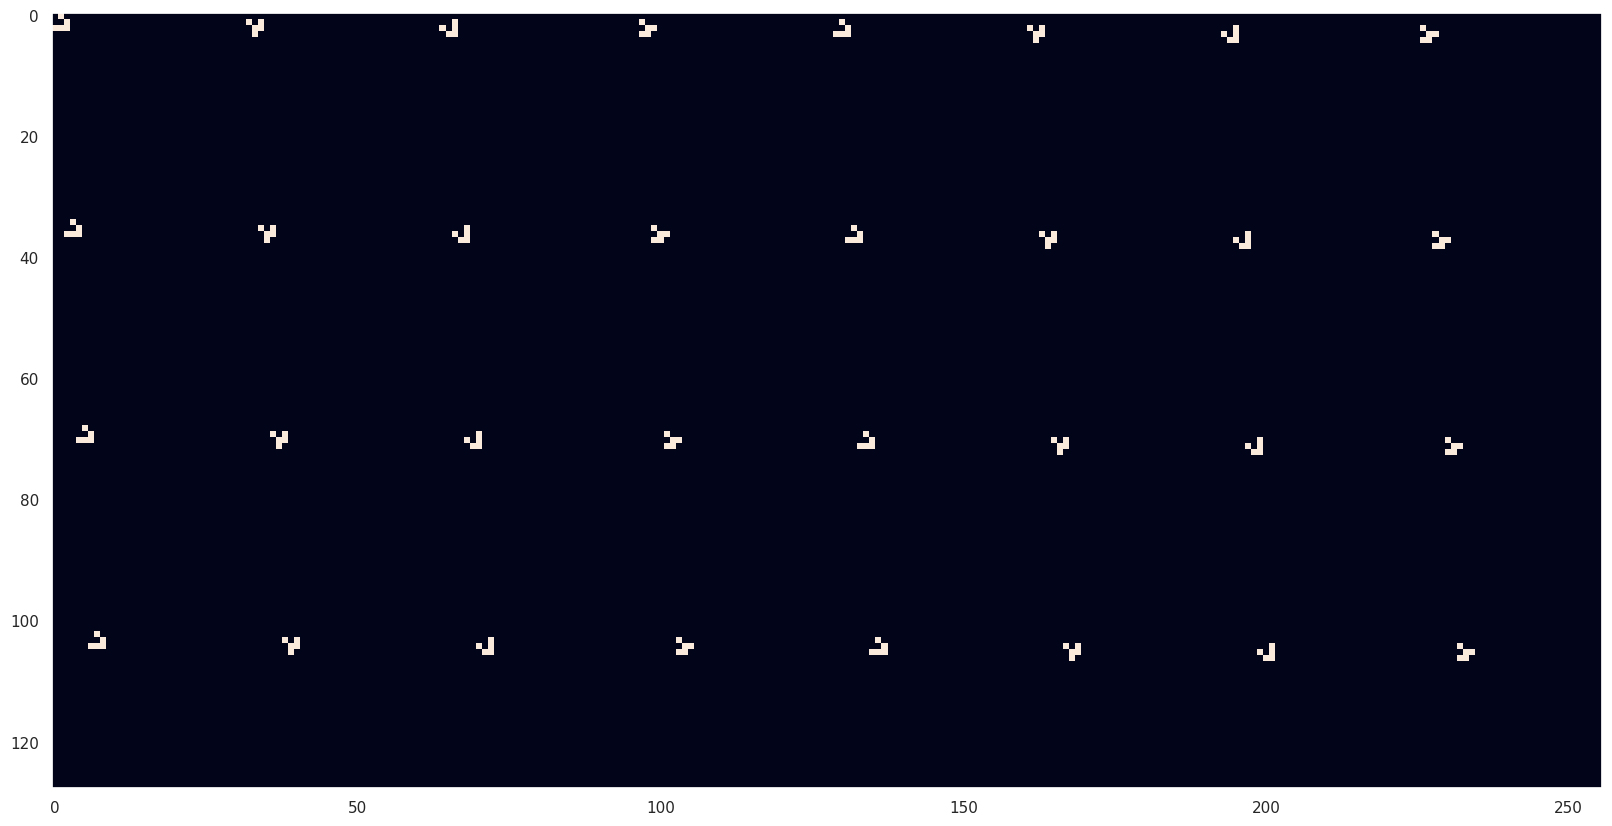

In [8]:
plt.figure(figsize=(20, 20))
plt.imshow(rearrange(vid, "(R C) H W -> (R H) (C W)", R=4))
plt.grid(False)
plt.show()

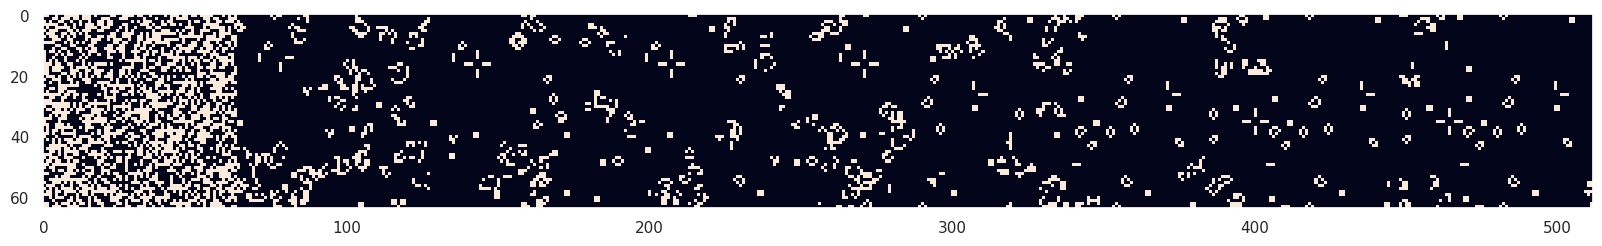

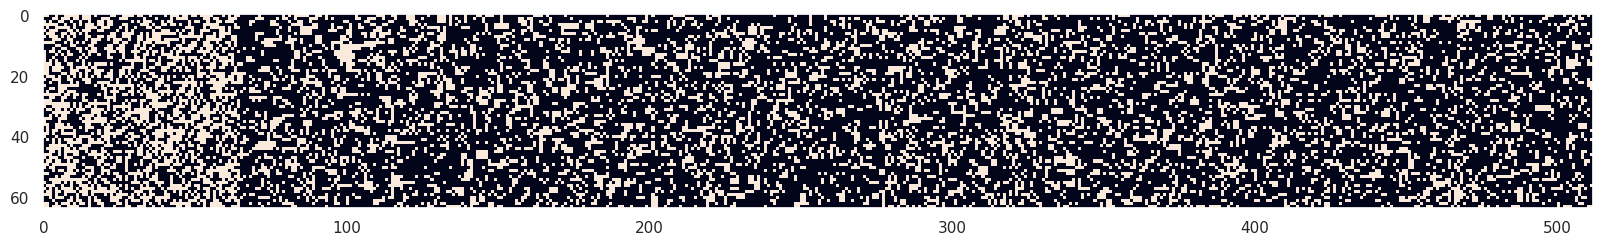

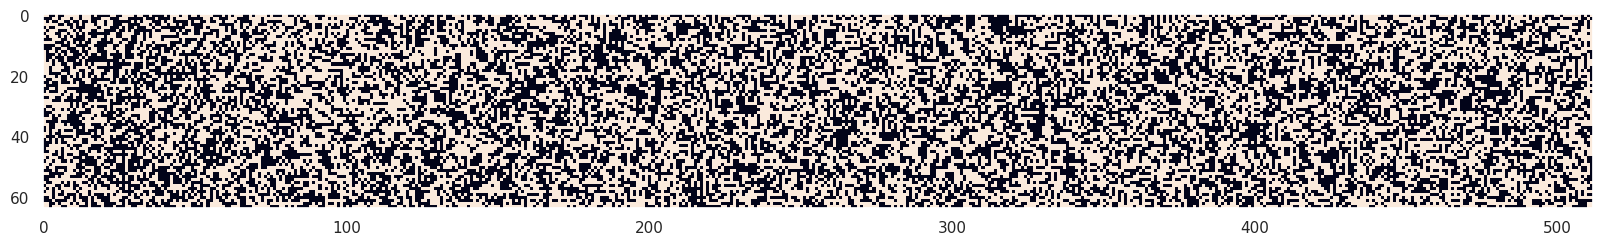

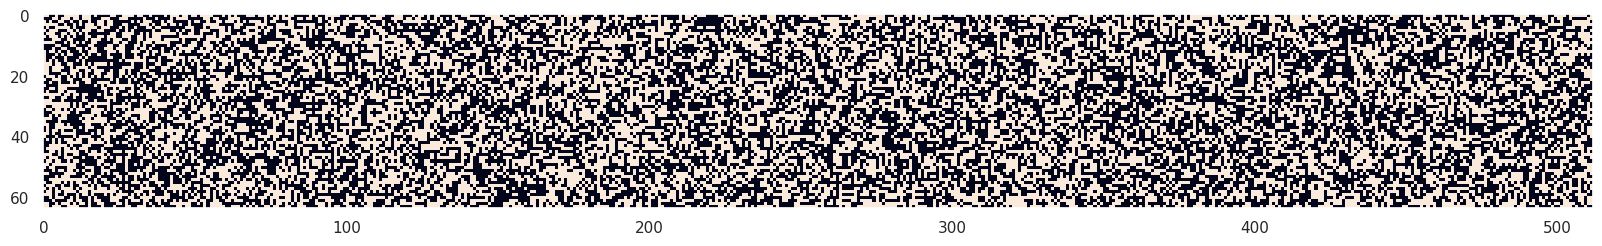

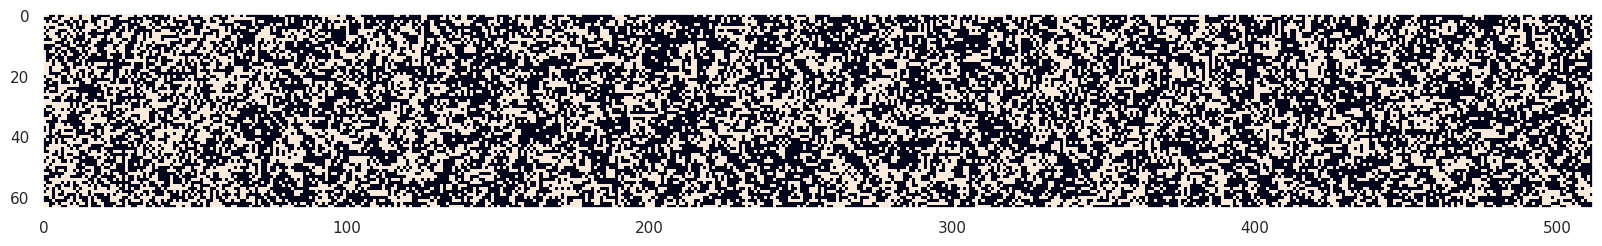

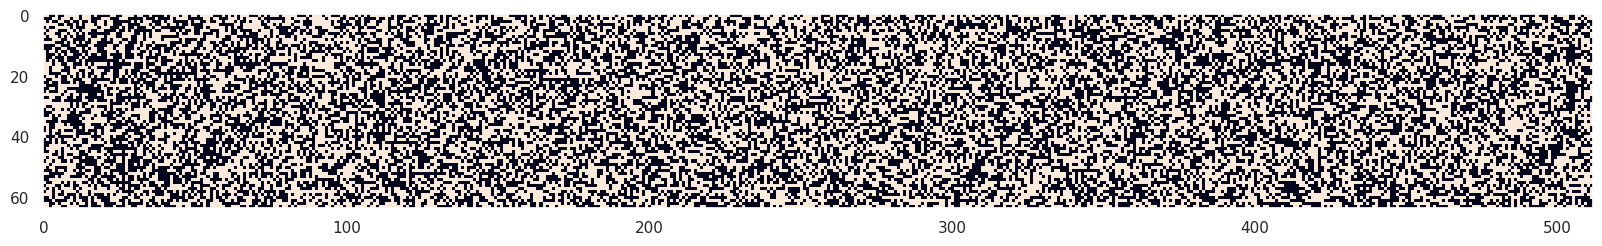

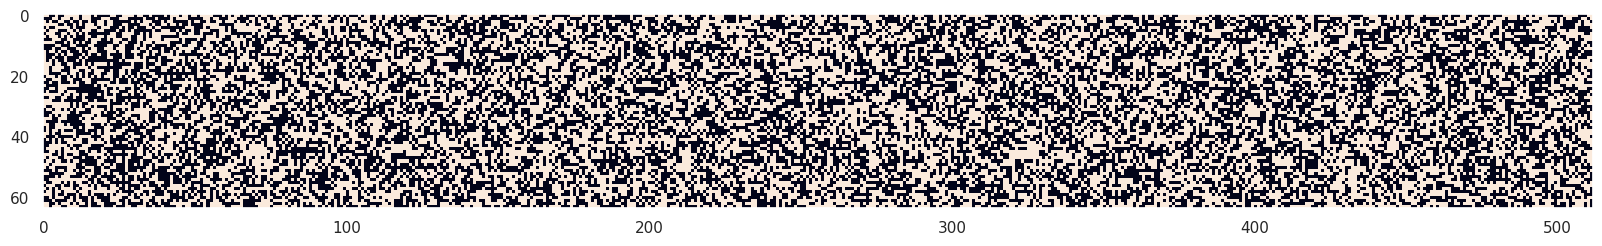

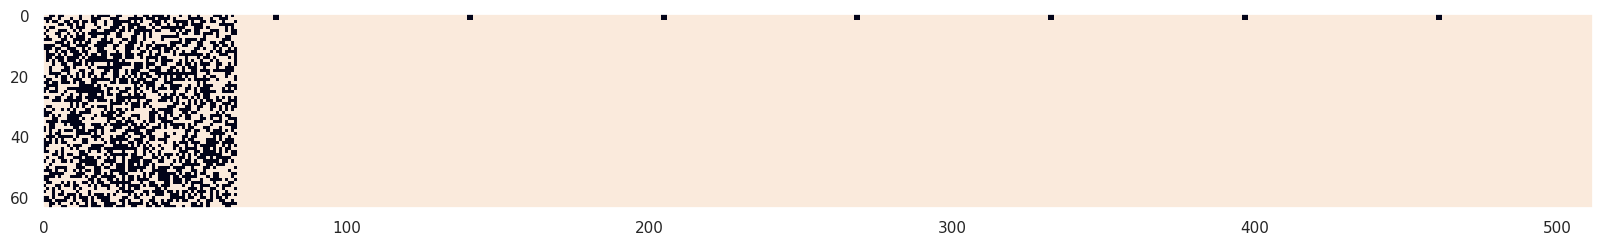

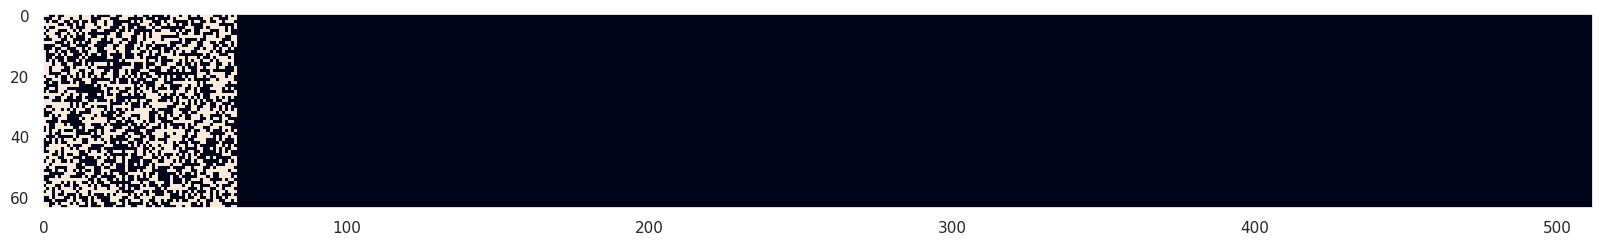

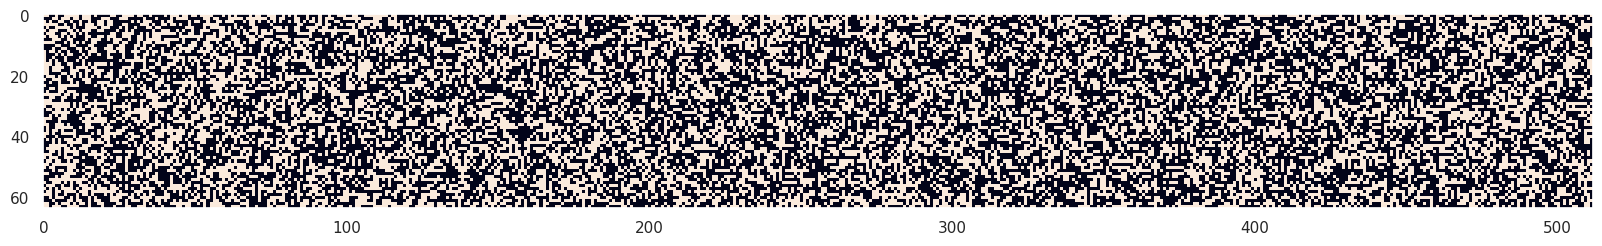

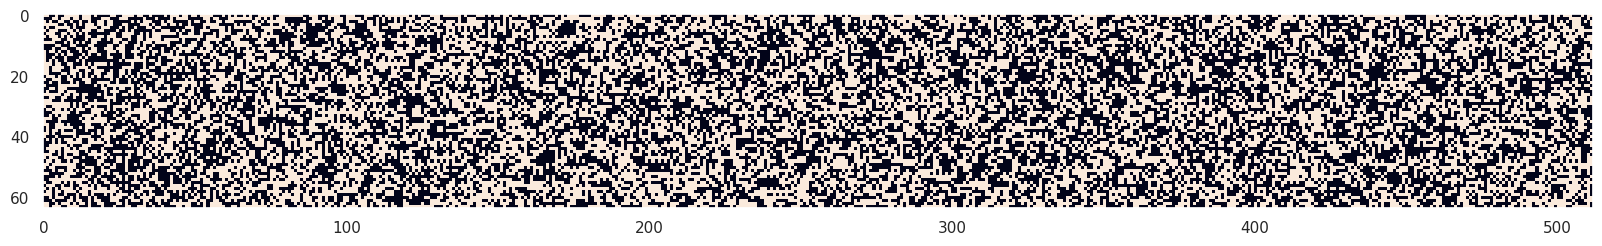

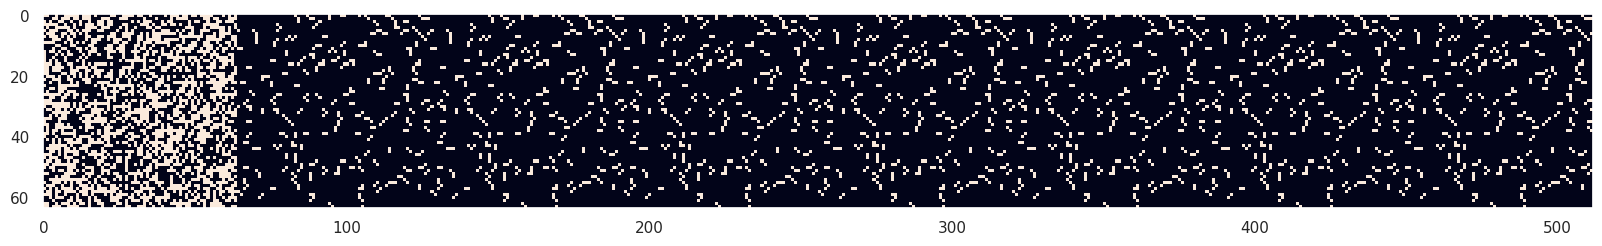

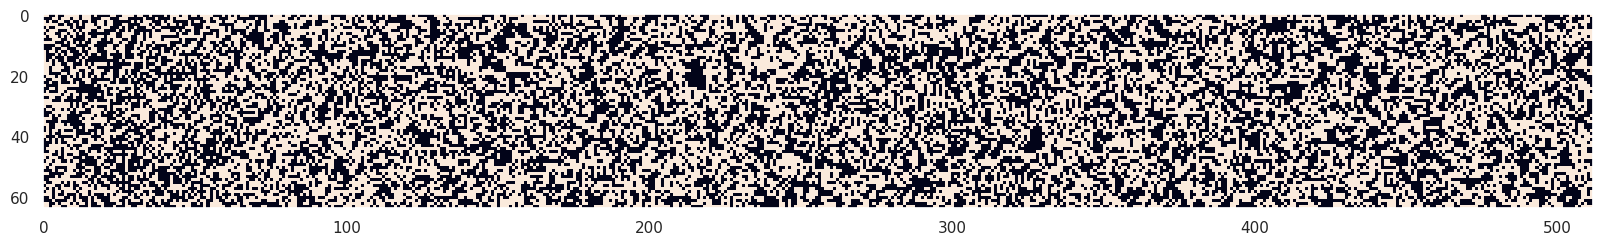

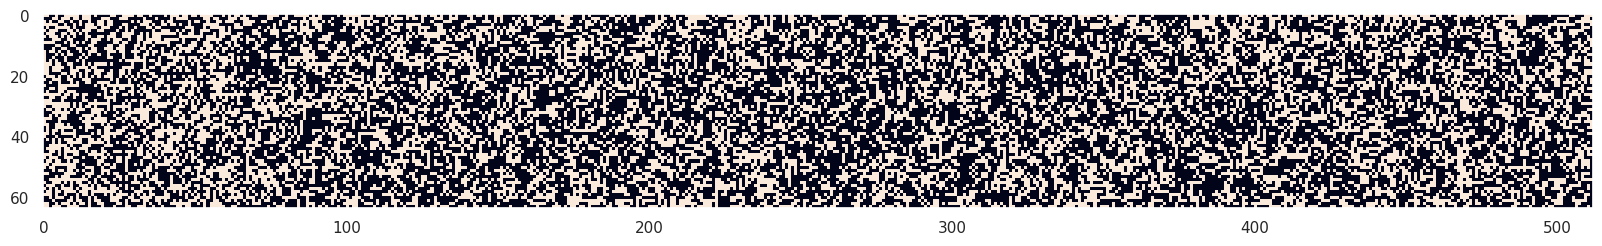

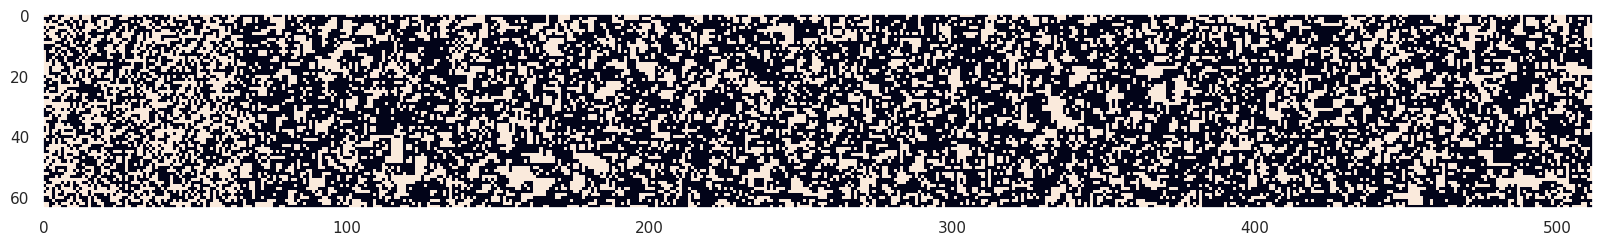

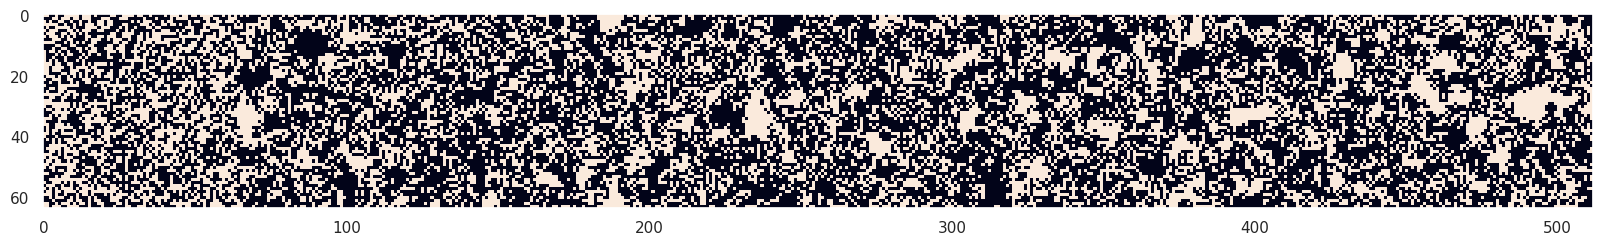

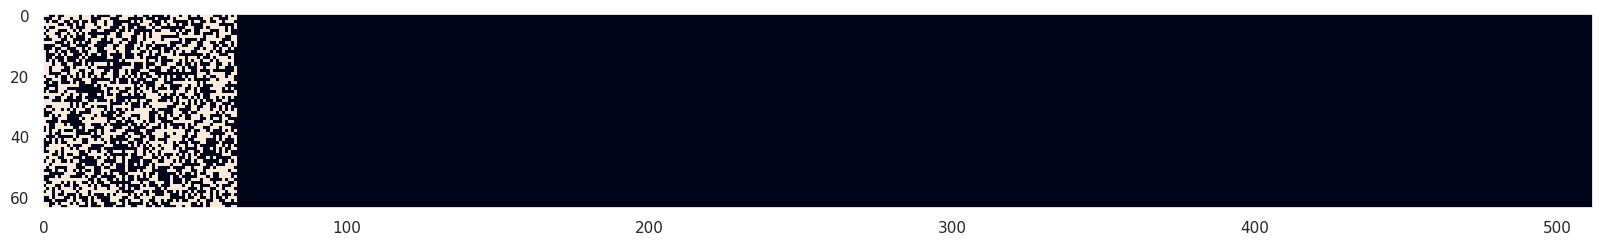

In [9]:
rng = jax.random.PRNGKey(1)
x = jax.random.randint(rng, shape=(64, 64), minval=0, maxval=2)

_, vid = jax.lax.scan(partial(step_GoL, params=params_gol), x, None, length=512)
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(vid[::64], "(R C) H W -> (R H) (C W)", R=1)); plt.grid(False)
plt.show()

for i in range(16):
    rng = jax.random.PRNGKey(i)
    params = jax.random.randint(rng, shape=(18, ), minval=0, maxval=2)
    _, vid = jax.lax.scan(partial(step_GoL, params=params), x, None, length=512)
    plt.figure(figsize=(20, 5))
    plt.imshow(rearrange(vid[::64], "(R C) H W -> (R H) (C W)", R=1)); plt.grid(False)
    plt.show()
    

In [14]:
from clip_jax import MyFlaxCLIP

In [15]:
clip_model = MyFlaxCLIP()

/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
clip_model.embed_img(jnp.zeros((224, 224, 3))).shape

(512,)

In [132]:
bs = 128*8
n_steps = 512
n_steps_clip = n_steps//8

resize_fn = partial(jax.image.resize, shape=(224, 224), method='nearest')

@jax.jit
def eval_params(params):
    rng = jax.random.PRNGKey(0)
    x = jax.random.randint(rng, shape=(bs, 64, 64), minval=0, maxval=2)
    step_fn = partial(step_GoL, params=params)
    _, vid = jax.lax.scan(jax.vmap(step_fn), x, None, length=512)
    vid = rearrange(vid[::n_steps_clip], "T B H W -> B T H W")
    vid_clip = jax.vmap(jax.vmap(resize_fn))(vid)
    vid_clip = repeat(vid_clip, "... -> ... 3")
    z_img = jax.vmap(jax.vmap(clip_model.embed_img))(vid_clip)
    scores = (z_img@z_img.mT)
    scores = jax.vmap(partial(jnp.tril, k=-1))(scores)
    distances = (-scores).min(axis=-1).mean(axis=0)
    return distances, scores


In [133]:
rng = jax.random.PRNGKey(0)
params = jax.random.randint(rng, shape=(18, ), minval=0, maxval=2)
distances, scores = eval_params(params)

(-0.97, -1.0)

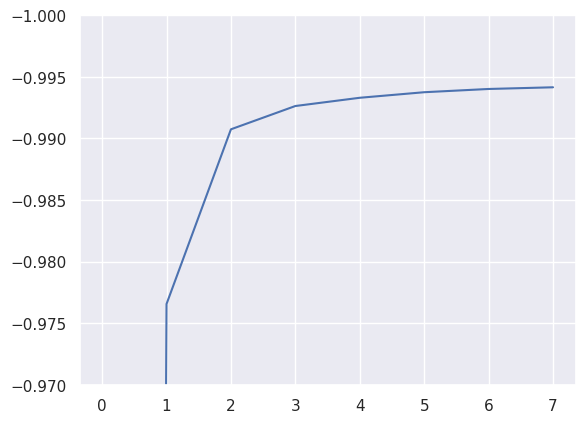

In [134]:
plt.plot(distances)
plt.ylim(-0.97, -1.)

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.97, -1.0)

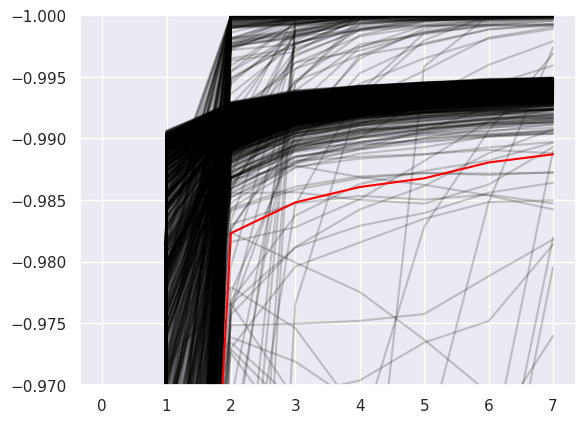

In [138]:
d = []
for i in tqdm(range(1000)):
    rng = jax.random.PRNGKey(i)
    params = jax.random.randint(rng, shape=(18, ), minval=0, maxval=2)
    distances, _ = eval_params(params)
    plt.plot(distances, c='black', alpha=0.2)
    d.append(distances)

distances_gol, _ = eval_params(params_gol)
plt.plot(distances_gol, c='red')
plt.ylim(-0.97, -1.)

In [139]:
d = jnp.stack(d)
d.shape

(1000, 8)

(-0.95, -1.0)

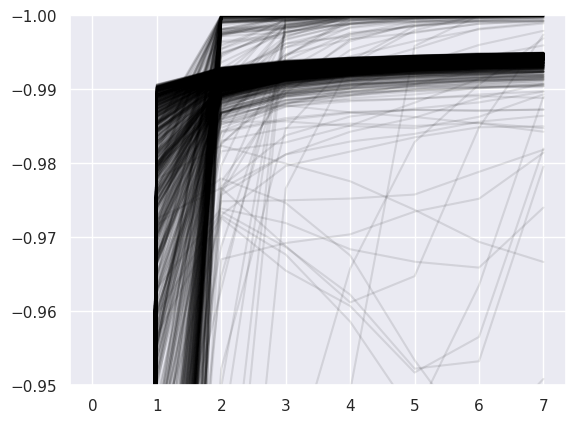

In [145]:
plt.plot(d.T, c='black', alpha=0.1)
plt.ylim(-0.95, -1.)

In [146]:
d.shape

(1000, 8)

(-0.9, -1.0)

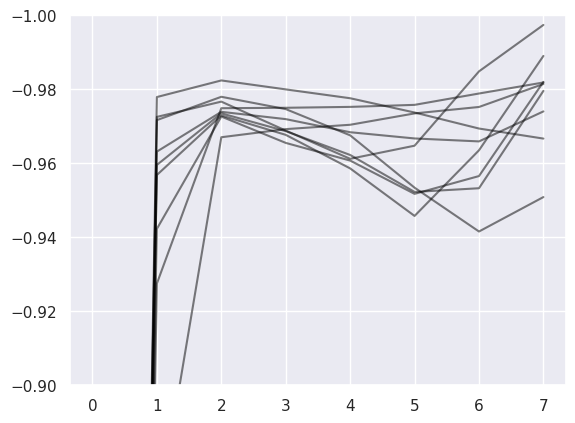

In [152]:
plt.plot(d[d[:, 5]>-0.98].T, c='black', alpha=0.5)
plt.ylim(-0.9, -1.)

  0%|          | 0/500 [00:00<?, ?it/s]

(-0.97, -1.0)

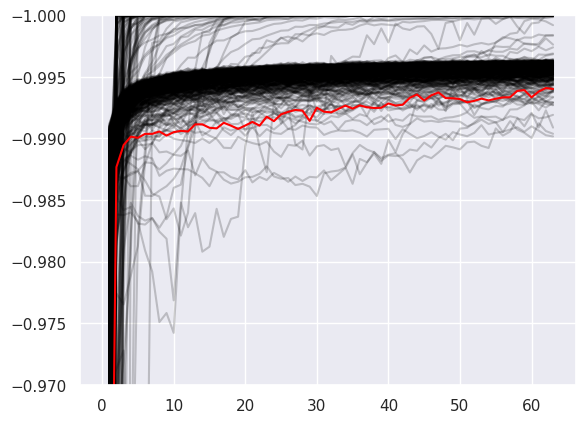

In [117]:
for i in tqdm(range(500)):
    rng = jax.random.PRNGKey(i)
    params = jax.random.randint(rng, shape=(18, ), minval=0, maxval=2)
    distances = eval_params(params)
    plt.plot(distances, c='black', alpha=0.2)

distances_gol = eval_params(params_gol)
plt.plot(distances_gol, c='red')
plt.ylim(-0.97, -1.)